,,degrees_east,degrees_north,UTC,millibars,degrees true,knots,knots,meters,seconds,degrees_true,meters,degrees_C,degrees_C,degrees_C,dimensionless,percent,degrees,degrees_true,seconds,

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# 加载数据
df_Ballycotton = pd.read_csv("./dataProcessed/1训练集5040.csv",encoding = "utf-8",index_col=['time'],parse_dates = ["time"],usecols = ['time','Water_Level'])
# 转化为时间序列
# df_Ballycotton['time'] = pd.to_datetime(df_Ballycotton['time'])
# 设置时间索引
# df_Ballycotton = df_Ballycotton.set_index("time")


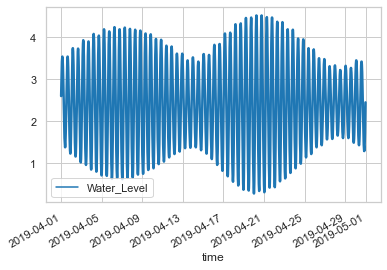

In [38]:
# 画图
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.set_theme(style="whitegrid")
# dataPlot = df_Ballycotton.loc[:,"Water_Level_LAT"]
sns.lineplot(data=df_Ballycotton, palette="tab10", linewidth=2.5,ax=ax)
# 将x轴斜过来显示更好看
fig.autofmt_xdate()

In [40]:
# 数据缺失情况
sum(df_Ballycotton.loc[:,'Water_Level'].isna())

0

Data loading...


100%|██████████| 19306/19306 [00:00<00:00, 877409.37it/s]

测试集大小为5792
Model loading...


Training...
torch.Size([10, 30, 1])


E:\Anaconda3\envs\mytorch\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1, 30, 1])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 batch: 0 | loss: 0.013064631260931492
Epoch: 0 batch: 10 | loss: 0.24704188108444214
Epoch: 0 batch: 20 | loss: 0.011444412171840668
Epoch: 0 batch: 30 | loss: 0.18733367323875427
Epoch: 0 batch: 40 | loss: 0.007031187415122986
Epoch: 0 batch: 50 | loss: 0.021045492962002754
Epoch: 0 batch: 60 | loss: 0.10182536393404007
Epoch: 0 batch: 70 | loss: 0.03590011224150658
Epoch: 0 batch: 80 | loss: 0.11893891543149948
Epoch: 0 batch: 90 | loss: 0.020831706002354622
Epoch: 0 batch: 100 | loss: 0.03370671346783638
Epoch: 0 batch: 110 | loss: 0.026399601250886917
Epoch: 0 batch: 120 | loss: 0.05260553956031799
Epoch: 0 batch: 130 | loss: 0.035661883652210236
Epoch: 0 batch: 140 | loss: 0.016865963116288185
Epoch: 0 batch: 150 | loss: 0.017515137791633606
Epoch: 0 batch: 160 | loss: 0.020106879994273186
Epoch: 0 batch: 170 | loss: 0.03514895960688591
Epoch: 0 batch: 180 | loss: 0.021406790241599083
Epoch: 0 batch: 190 | loss: 0.023034732788801193
Epoch: 0 batch: 200 | loss: 0.016352238

176it [00:01, 207.13it/s]

torch.Size([10, 30, 1])


194it [00:01, 125.15it/s]


r2Score:  0.8304588986235648
meanSquaredError:  0.00963681919891161
meanAbsoluteError:  0.07215783696538687


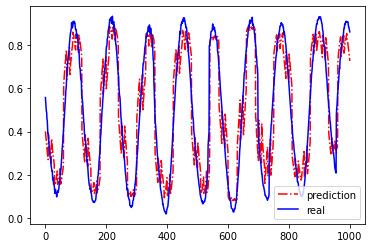

In [1]:
import torch
from torch.utils.data import DataLoader

from config import Config

from utils.dataTools import *
from utils.models import lstm_reg,CNNBiLSTM
from utils.trainer import RNNtrain,evaluate,CNNBiLstmtrain

if __name__ == '__main__':
    config = Config()

    print("Data loading...")
    # 序列数据
    dataset = mydataReader("./dataProcessed/testData.csv")

    # 创建X/Y
    # 划分训练集和测试集，70% 作为训练集
    (train_X ,train_Y ),(test_X ,test_Y )= dataset.split(lookback=config.lookback,trainSet_ratio=0.7)

    # 创建Pytorch使用的dataset
    trainSet = custom_dataset(train_X,train_Y)
    testSet = custom_dataset(test_X,test_Y)

    train_loader = DataLoader(trainSet, batch_size = config.batch_size,
                              shuffle=False, pin_memory=True, num_workers=4, drop_last=True)
    test_loader = DataLoader(testSet, batch_size = config.batch_size,
                            shuffle=False, pin_memory=True, num_workers=4, drop_last=False)

    print("Model loading...")
    model = lstm_reg(1,hidden_size=12,num_layers=1).to(config.device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                 lr=config.learning_rate, weight_decay=config.weight_decay)

    print("Training...")
    model = RNNtrain(model,
                  loader=train_loader,
                  criterion=criterion,
                  optimizer=optimizer,
                  config=config)

    print("Testing...", round(len(testSet)/config.batch_size))
    r2Score,meanSquaredError,meanAbsoluteError = evaluate(model, test_loader, config)


In [2]:
np.sqrt(0.00963681919891161)

0.09816730208634447

In [4]:
train_Y.shape

(13514, 1)

[14:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "randam_state" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.0005923981
6.888661e-05
0.9895779060372912
[0.5565522  0.5383942  0.51520455 ... 0.3329687  0.31874862 0.31809232]
[0.569362   0.53649247 0.5216427  ... 0.34392446 0.31983602 0.3050364 ]


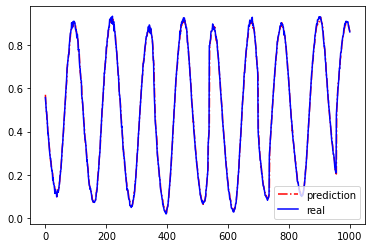

In [9]:
# 加载xgboost模型
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb

# 定义模型
model = xgb.XGBRegressor(max_depth = 6,learning_rate = 0.05,n_estimators = 100,randam_state=42)

# 训练
model.fit(train_X.squeeze(),train_Y.squeeze())
test_predict=model.predict(test_X.squeeze())
train_predict = model.predict(train_X.squeeze())

# MSE
msetest=mean_squared_error(test_Y.squeeze(),test_predict)
msetrain=mean_squared_error(train_Y.squeeze(),train_predict)
print(msetest)
print(msetrain)

# R2-score
r2Test = r2_score(test_Y.squeeze(),test_predict)
print(r2Test)

# 画出实际结果和预测的结果
import matplotlib.pyplot as plt
y = test_Y.squeeze()
y_pre = test_predict
print(y)
print(y_pre)
plt.plot(range(len(y[:1000])),y_pre[:1000],color = 'red',linewidth = 1.5,linestyle = '-.',label='prediction')
plt.plot(range(len(y[:1000])),y[:1000],color = 'blue',linewidth = 1.5,linestyle = '-', label='real')
plt.legend(loc='best')